In [1]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

# 関数描写

In [2]:
n = 2
A = 10

In [3]:
def f(x):
    return A*n + np.sum(x**2 - A * np.cos(2* np.pi * x))

In [4]:
x = np.linspace(-2, 2, 41)
y = np.linspace(-2, 2, 41)
X, Y = np.meshgrid(x, y)
Z = np.zeros((len(x), len(y)))
for i, xi in enumerate(x):
    for j, yj in enumerate(y):
        Z[i, j] = f(np.array([xi, yj]))
             

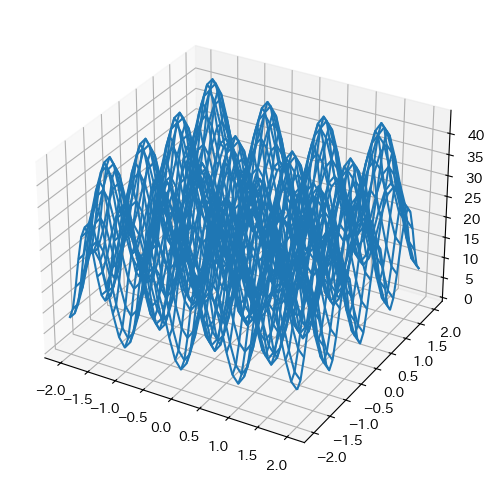

In [5]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': '3d'})
ax.plot_wireframe(X, Y, Z);

# Rasrigin関数(非凸関数)の最小化

In [6]:
n = 50
num_itr = 150
K = 50
adam_lr = 5e-6
max_inner = 100

A = 10

In [7]:
def f(x):
    return A*n + jnp.sum(x**2 - A * jnp.cos(2* jnp.pi * x))

In [8]:
# -- ベクトルで微分をgrad()で無理やりやるなら　-- 
# df = jax.grad(f)
# vec_df = jax.vmap(df, in_axes=-1, out_axes=-1)
# ----------------------------------------#
vec_df  = jax.jacrev(f) # ヤコビアン求める関数
batch_vec_df = jax.jit(jax.vmap(vec_df, in_axes=-1, out_axes=-1))

In [9]:
def mini_batch(K):
    xini = 5.0 * np.random.randn(n ,K)
    return jnp.array(xini)

In [10]:
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=-1, out_axes=-1)

In [11]:
@partial(jax.jit, static_argnums=0)
def GD(max_itr, xini, eta):
    x = xini
    for i in range(max_itr):
        x -= eta * batch_vec_df(x)
    return x

def comp_mse(max_itr, eta):
    xini = mini_batch(K)
    x_hat = GD(max_itr, xini, eta)
    return jnp.sum(batch_get_dot(x_hat)) / K

In [12]:
res_df = pd.DataFrame()
res_df["Iteration"] = list(range(num_itr))
res_df["GD ($\eta$ = 0.02)"] = [float(comp_mse(i+1, 0.02)) for i in range(num_itr)]

In [13]:
res_df["GD ($\eta$ = 0.01)"] = [float(comp_mse(i+1, 0.01)) for i in range(num_itr)]

In [14]:
res_df["GD ($\eta$ = 0.005)"] = [float(comp_mse(i+1, 0.005)) for i in range(num_itr)]

In [15]:
def DU_GD(max_itr, xini, eta):
    x = xini
    for i in range(max_itr):
        x -= eta[i] * batch_vec_df(x)
    return x

In [16]:
def loss(max_itr, xini, eta):
    x_hat = DU_GD(max_itr, xini, eta)
    return jnp.sum(batch_get_dot(x_hat)) / K

In [17]:
opt_init, opt_update, get_params = optimizers.adam(adam_lr)

@partial(jax.jit, static_argnums=0)
def step(max_itr, xini, step, opt_state):
    value, grads = jax.value_and_grad(loss, argnums=-1)(max_itr, xini, get_params(opt_state))
    new_opt_state = opt_update(step, grads, opt_state)
    return value, new_opt_state

def train(eta):
    opt_state = opt_init(eta)
    for itr in trange(num_itr, leave=False):
        for i in range(max_inner):
            x_ini = mini_batch(K)
            value, opt_state = step(itr+1, x_ini, i, opt_state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params(opt_state)

In [18]:
def comp_mse_DUGD(max_itr, eta):
    x_ini = mini_batch(K)
    x_hat = DU_GD(max_itr, x_ini, eta)
    return jnp.sum(batch_get_dot(x_hat)) / K, x_hat

In [19]:
# 手元のPCのスペックの都合でnum_itrを減らす
num_itr = 50
eta_init = 0.01 * jnp.ones(num_itr)
eta_trained = train(eta_init)

  0%|          | 0/50 [00:00<?, ?it/s]

loss:128.7999725341797  

In [20]:
DUGD_mse = [comp_mse_DUGD(i+1, eta_trained)[0] for i in range(num_itr)]
x_hat_ave_hist = [jnp.average(comp_mse_DUGD(i+1, eta_trained)[1][:,0]) for i in range(num_itr)]
res_df2 = pd.DataFrame()
res_df2["Iteration"] = range(num_itr)
res_df2["DU-GD"] = np.array(DUGD_mse)
res_df2["opt_param"] = np.array(eta_trained)
res_df2["x_hat_ave"] = np.array(x_hat_ave_hist)

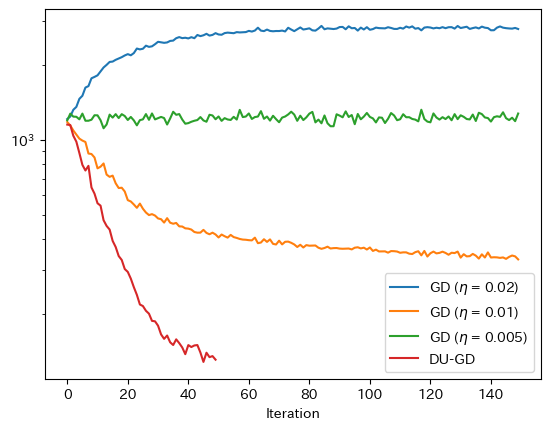

In [21]:
ax = res_df.plot(res_df.columns[0], res_df.columns[1:])
res_df2.plot(res_df2.columns[0], res_df2.columns[1], ax=ax)
plt.yscale("log")

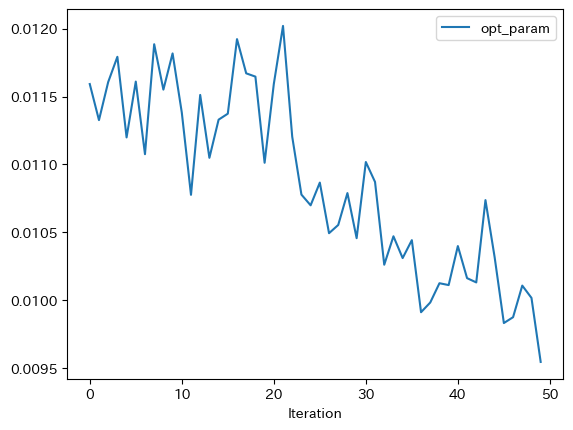

In [22]:
res_df2.plot(res_df2.columns[0], res_df2.columns[-2]);

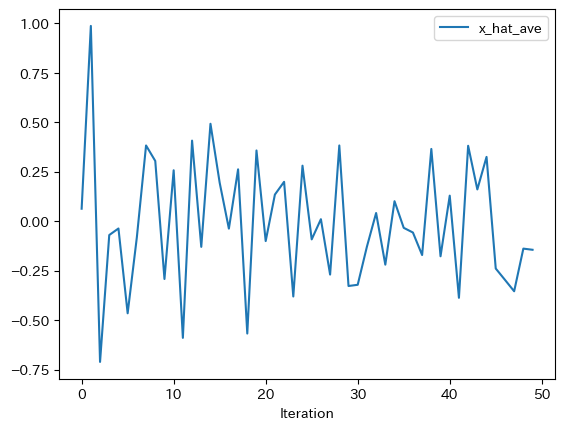

In [23]:
res_df2.plot(res_df2.columns[0], res_df2.columns[-1]);